In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

import util
import util2

import tensorflow as tf

tf.compat.v1.disable_eager_execution()

In [2]:
train_df = pd.read_csv("/content/train-small.csv")
valid_df = pd.read_csv("/content/valid-small.csv")

test_df = pd.read_csv("/content/test.csv")

train_df.head(10)
valid_df.head(10)
test_df.head(10)

Image  PatientId  Cardiomegaly  Emphysema  Effusion  Hernia  \
0  00021463_005.png      21463             0          0         1       1   
1  00019733_002.png      19733             0          0         0       1   
2  00021463_001.png      21463             0          0         0       1   
3  00017136_020.png      17136             0          0         0       1   
4  00027477_000.png      27477             0          0         0       1   
5  00006713_013.png       6713             0          0         0       1   
6  00029188_001.png      29188             0          0         0       1   
7  00020915_000.png      20915             0          0         0       1   
8  00017735_000.png      17735             0          0         1       1   
9  00000003_001.png          3             0          0         0       1   

   Infiltration  Mass  Nodule  Atelectasis  Pneumothorax  Pleural_Thickening  \
0             1     0       0            1             0                   0   
1             0     0       0            1             0                   0   
2             0     0       0            0             0                   0   
3             0     0       0            0             0                   0   
4             1     0       0            0             0                   0   
5             0     0       0            0             0                   0   
6             0     0       0            0             0                   0   
7             0     0       0            0             0                   0   
8             0     0       0            0             0                   0   
9             0     0       0            0             0                   0   

   Pneumonia  Fibrosis  Edema  Consolidation  
0          0         0      1              0  
1          0         0      0              0  
2          0         0      0              0  
3          0         0      0              0  
4          0         0      0              0  
5          0         0      0              0  
6          0         0      0              0  
7          0         0      0              0  
8          0         0      0              0  
9          0         0      0              0

In [3]:
labels = ['Cardiomegaly',
          'Emphysema',
          'Effusion',
          'Hernia',
          'Infiltration',
          'Mass',
          'Nodule',
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening',
          'Pneumonia',
          'Fibrosis',
          'Edema',
          'Consolidation']

In [4]:
# Checking for Data Leakage
def check_for_leakage(df1, df2, patient_col):

    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)

    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    leakage = len(patients_in_both_groups) > 0

    return leakage

In [5]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))


leakage between train and test: False
leakage between valid and test: False


In [6]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):

    print("getting train generator...")
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)

    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))

    return generator

In [7]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):

    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=IMAGE_DIR,
        x_col="Image",
        y_col=labels,
        class_mode="raw",
        batch_size=sample_size,
        shuffle=True,
        target_size=(target_w, target_h))

    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)

    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [8]:
import os
import urllib.request
import tarfile

# URLs for the tar.gz files
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
    'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
    'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
    'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
    'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
    'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
    'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
    'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

# target directory
target_folder = '/content/datasets'
os.makedirs(target_folder, exist_ok=True)

for idx, link in enumerate(links):
    fn = os.path.join(target_folder, f'images_{idx+1}.tar.gz')
    print('Downloading', fn, '...')
    urllib.request.urlretrieve(link, fn)  # Download the tar.gz file

    print('Extracting', fn, '...')
    with tarfile.open(fn, 'r:gz') as tar:
        tar.extractall(target_folder)  # Extract the contents of the tar.gz file

    print('Deleting', fn, '...')
    os.remove(fn)  # Delete the tar.gz file after extraction

print("Extraction complete. Please check the extracted files.")


Extracting /content/datasets/images_1.tar.gz ...
Deleting /content/datasets/images_1.tar.gz ...
Extracting /content/datasets/images_2.tar.gz ...
Deleting /content/datasets/images_2.tar.gz ...
Extracting /content/datasets/images_3.tar.gz ...
Deleting /content/datasets/images_3.tar.gz ...
Extracting /content/datasets/images_4.tar.gz ...
Deleting /content/datasets/images_4.tar.gz ...
Extracting /content/datasets/images_5.tar.gz ...
Deleting /content/datasets/images_5.tar.gz ...
Extracting /content/datasets/images_6.tar.gz ...
Deleting /content/datasets/images_6.tar.gz ...
Extracting /content/datasets/images_7.tar.gz ...
Deleting /content/datasets/images_7.tar.gz ...
Extracting /content/datasets/images_8.tar.gz ...
Deleting /content/datasets/images_8.tar.gz ...
Extracting /content/datasets/images_9.tar.gz ...
Deleting /content/datasets/images_9.tar.gz ...
Extracting /content/datasets/images_10.tar.gz ...
Deleting /content/datasets/images_10.tar.gz ...
Extracting /content/datasets/images_11

In [9]:
IMAGE_DIR = "/content/datasets/images"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 1000 validated image filenames.
getting train and valid generators...
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


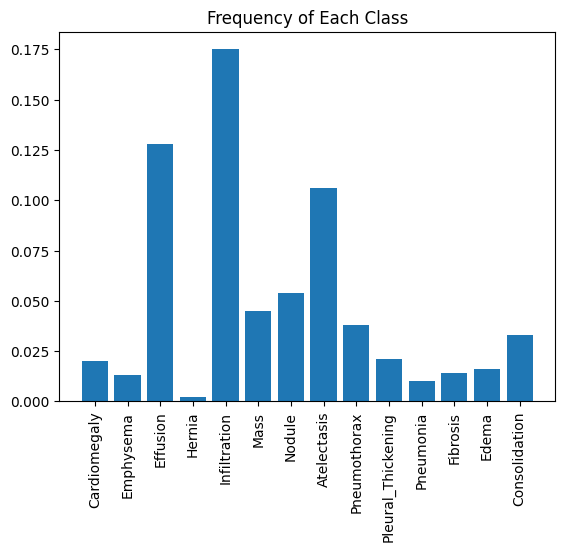

Cardiomegaly: 0.02
Emphysema: 0.01
Effusion: 0.13
Hernia: 0.00
Infiltration: 0.17
Mass: 0.04
Nodule: 0.05
Atelectasis: 0.11
Pneumothorax: 0.04
Pleural_Thickening: 0.02
Pneumonia: 0.01
Fibrosis: 0.01
Edema: 0.02
Consolidation: 0.03


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have labels and train_generator.labels defined

plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

# Extract mean frequencies
mean_frequencies = np.mean(train_generator.labels, axis=0)

# Print the frequencies
for label, frequency in zip(labels, mean_frequencies):
    print(f"{label}: {frequency:.2f}")


In [11]:
def compute_class_freqs(labels):

    # total number of patients (rows)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [12]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

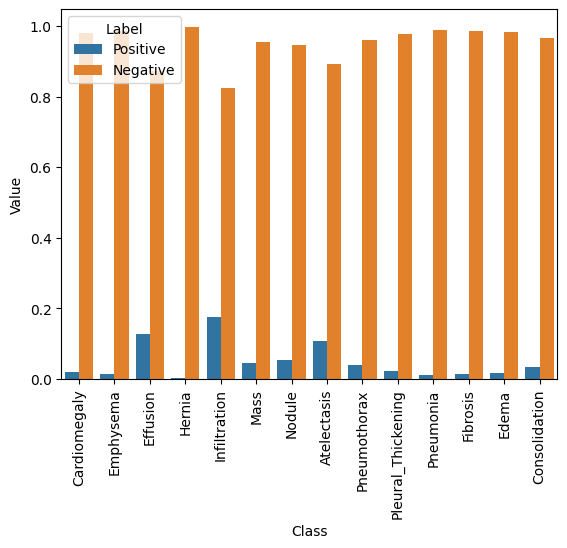

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have labels, freq_pos, and freq_neg lists defined already

data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
neg_data = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l, v in enumerate(freq_neg)])

data = pd.concat([data, neg_data], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.show()


In [17]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

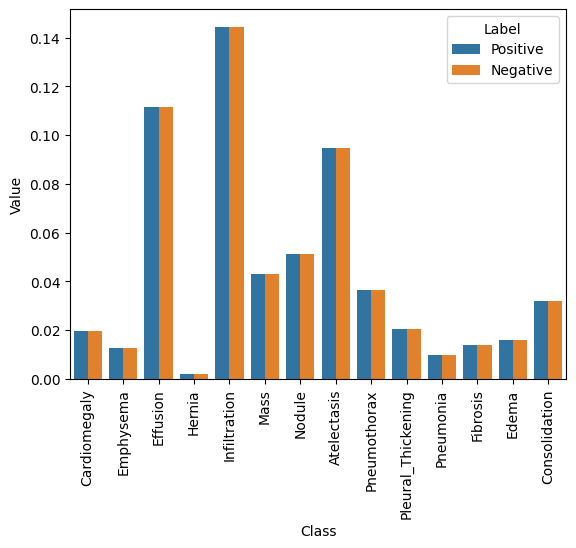

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have labels, pos_contribution, and neg_contribution lists defined already

# Create DataFrame for positive contributions
pos_data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})

# Create DataFrame for negative contributions
neg_data = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l, v in enumerate(neg_contribution)])

# Concatenate the two DataFrames
data = pd.concat([pos_data, neg_data], ignore_index=True)

# Plot the data
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.show()


In [19]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):

    def weighted_loss(y_true, y_pred):

        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg

        return loss

        ### END CODE HERE ###
    return weighted_loss

In [20]:
class_count = len(labels)



In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import EfficientNetB0 # Import EfficientNetB0

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # Assuming train_gen is your ImageDataGenerator

efficientnet = EfficientNetB0(input_shape=img_shape, include_top=False, weights='imagenet') # Load EfficientNetB0 without the top layers

model = Sequential()

# Add EfficientNet backbone
model.add(efficientnet)

# Add custom dense layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(class_count, activation='softmax'))

model.summary()


NameError: name 'train_gen' is not defined

# Initial Layers:
 Input layer (input_2)

Zero-padding (zero_padding2d_3)

Convolutional layer with batch normalization and ReLU activation (conv1/conv, conv1/bn, conv1/relu)


Zero-padding (zero_padding2d_4)

Pooling layer (pool1)

# Multiple Stacked Blocks
(e.g., conv2_block1, conv2_block2, ..., conv5_block16):

Blocks consist of multiple convolutional layers, batch normalization, and ReLU activation.
Each block typically has a shortcut connection (e.g., conv2_block1_concat) that merges the input with the output.
The number of blocks and their structure may vary across different sections (conv2, conv3, conv4, conv5).
Intermediate Pooling Layers:

Pooling layers after blocks (pool2_pool, pool3_pool, pool4_pool)

# Final Layers:
Batch normalization and ReLU activation (bn, relu)
Global average pooling (global_average_pooling2d_2)
Fully connected layer (dense_2), likely the output layer for classification

In [37]:
# create the base pre-trained model
base_model = DenseNet121(weights='/content/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [38]:
model.load_weights("/content/pretrained_model.h5")

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 zero_padding2d_8 (ZeroPadd  (None, None, None, 3)        0         ['input_5[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, None, None, 64)       9408      ['zero_padding2d_8[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1/conv[0][0]']    

In [39]:
# # Assuming test_generator is defined elsewhere in your code
predicted_vals = model.predict(test_generator, steps=len(test_generator))

# # Print the predicted values or use them as needed in your code
print(predicted_vals)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[[0.8040185  0.148196   0.7836129  ... 0.23338208 0.8131133  0.6767025 ]
 [0.14148985 0.20005754 0.47528052 ... 0.06826976 0.5375181  0.62648565]
 [0.21053173 0.3196506  0.3414172  ... 0.2623169  0.37459913 0.36849755]
 ...
 [0.03229919 0.35826302 0.48864377 ... 0.6532618  0.0611834  0.43429503]
 [0.24010897 0.24003899 0.38345033 ... 0.45081177 0.15054911 0.7438838 ]
 [0.14467916 0.52099836 0.9172695  ... 0.4128621  0.1179396  0.67214787]]


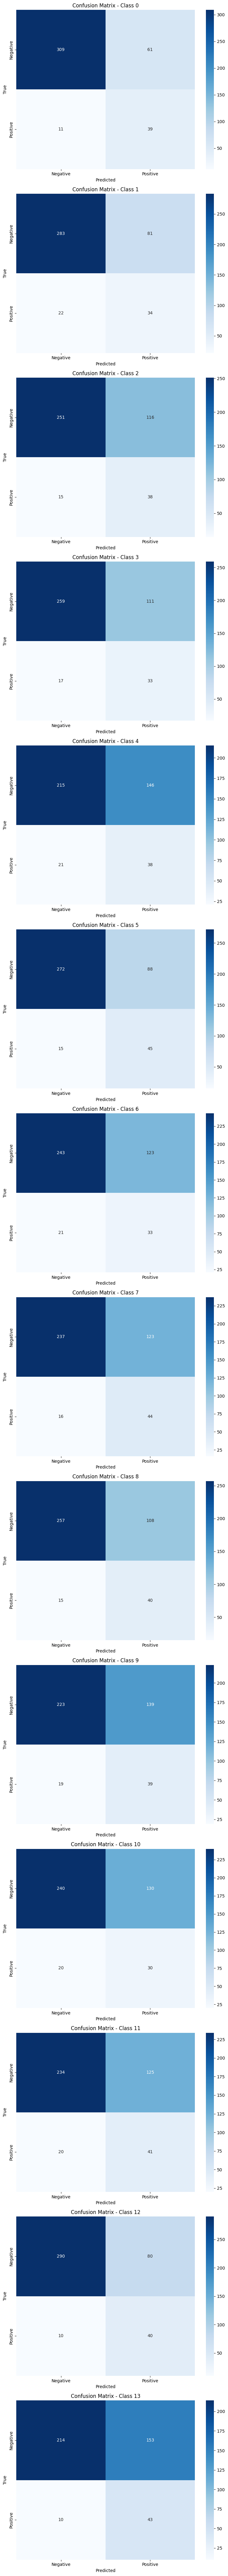

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

# Assuming test_generator.labels is a binary or multiclass representation of the true labels
true_labels = test_generator.labels  # Replace this line with the actual true labels

# Threshold for binary classification (you may need to adjust this based on your problem)
threshold = 0.5
predicted_classes = (predicted_vals > threshold).astype(int)

# Multilabel Confusion Matrix
mcm = multilabel_confusion_matrix(true_labels, predicted_classes)

# Plot Confusion Matrices for each class
num_classes = len(mcm)
fig, axes = plt.subplots(nrows=num_classes, ncols=1, figsize=(8, 6 * num_classes))

for i in range(num_classes):
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[i])
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
    axes[i].set_title(f'Confusion Matrix - Class {i}')

plt.tight_layout()
plt.show()


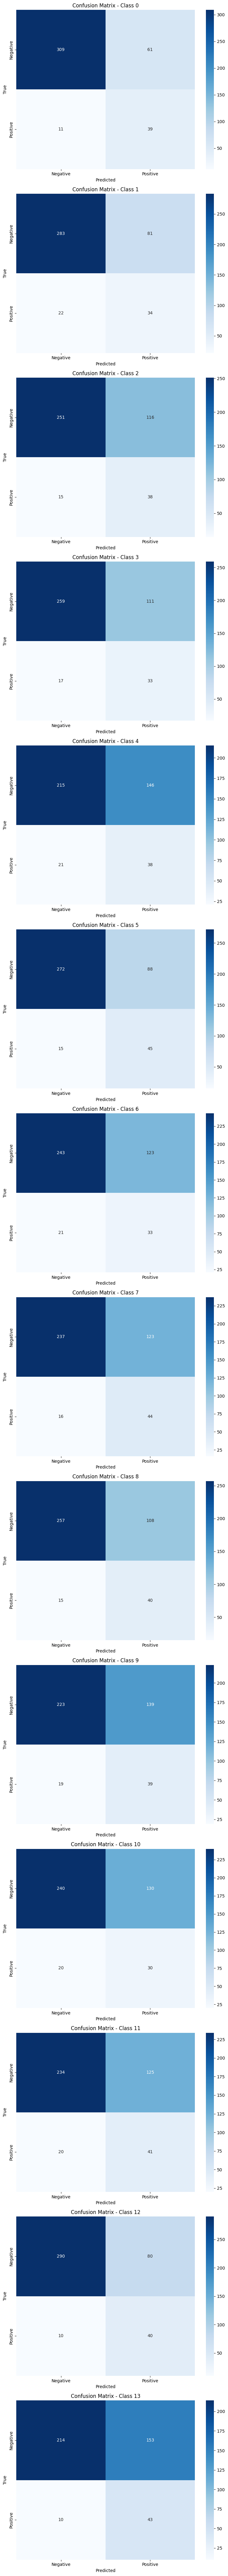

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

# Assuming test_generator.labels is a multilabel representation of the true labels
true_labels = test_generator.labels  # Replace this line with the actual true labels

# Convert predicted values to predicted classes
predicted_classes = (predicted_vals > 0.5).astype(int)  # Assuming binary classification

# Multilabel Confusion Matrix
mcm = multilabel_confusion_matrix(true_labels, predicted_classes)

# Plot Confusion Matrices for each class
num_classes = len(mcm)
fig, axes = plt.subplots(nrows=num_classes, ncols=1, figsize=(8, 6 * num_classes))

for i in range(num_classes):
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[i])
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
    axes[i].set_title(f'Confusion Matrix - Class {i}')

plt.tight_layout()
plt.show()


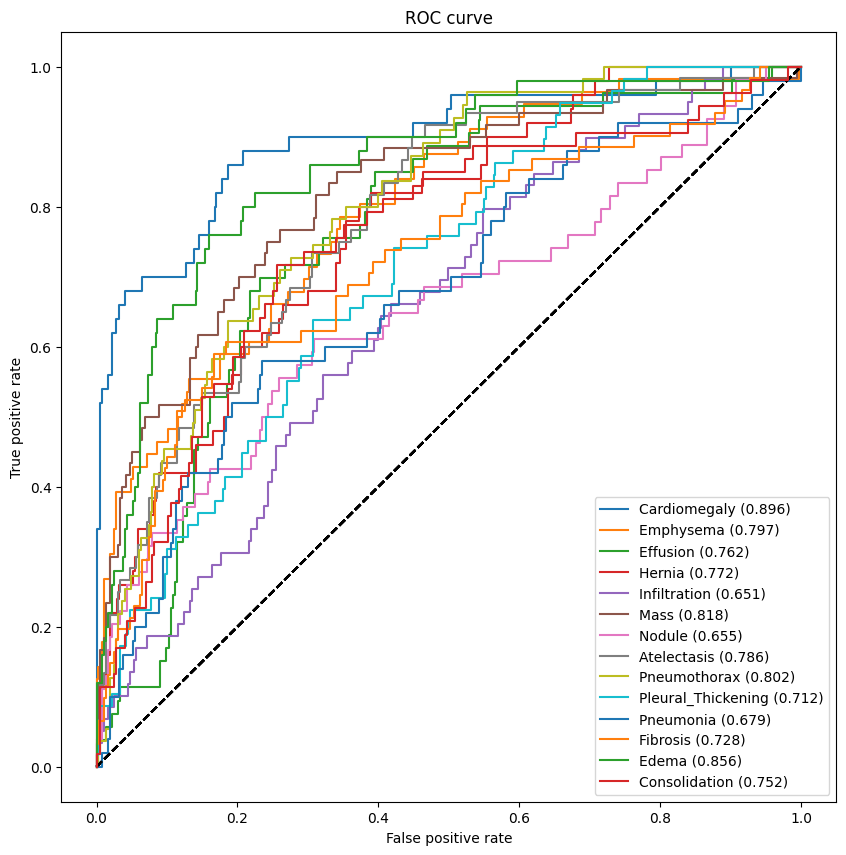

In [42]:
import util5

auc_rocs = util5.get_roc_curve(labels, predicted_vals, test_generator)

Cardiomegaly AUC: 0.8960
Emphysema AUC: 0.7968
Effusion AUC: 0.7619
Hernia AUC: 0.7722
Infiltration AUC: 0.6515
Mass AUC: 0.8185
Nodule AUC: 0.6550
Atelectasis AUC: 0.7859
Pneumothorax AUC: 0.8019
Pleural_Thickening AUC: 0.7117
Pneumonia AUC: 0.6795
Fibrosis AUC: 0.7284
Edema AUC: 0.8558
Consolidation AUC: 0.7518


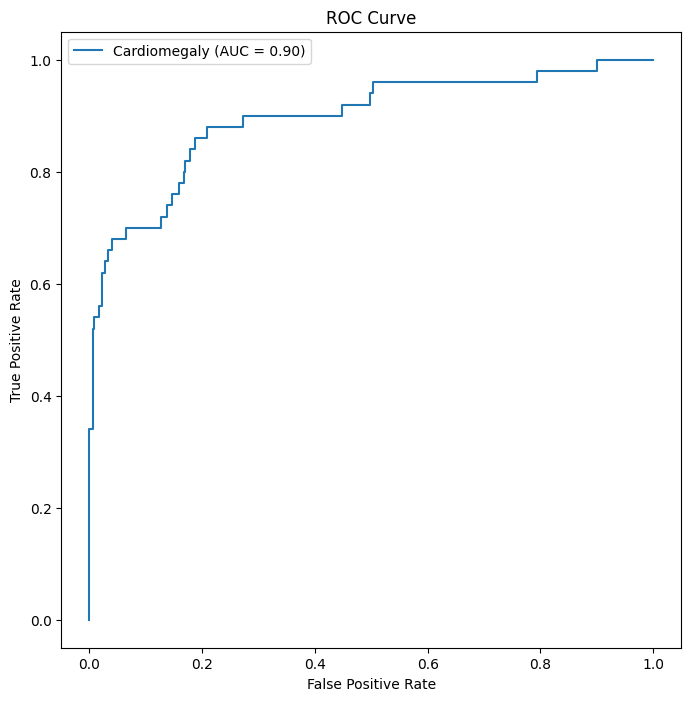

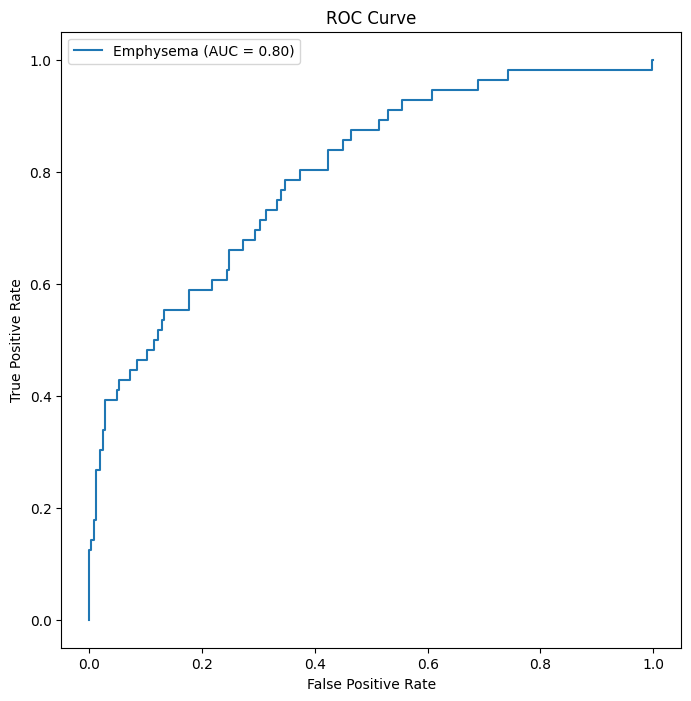

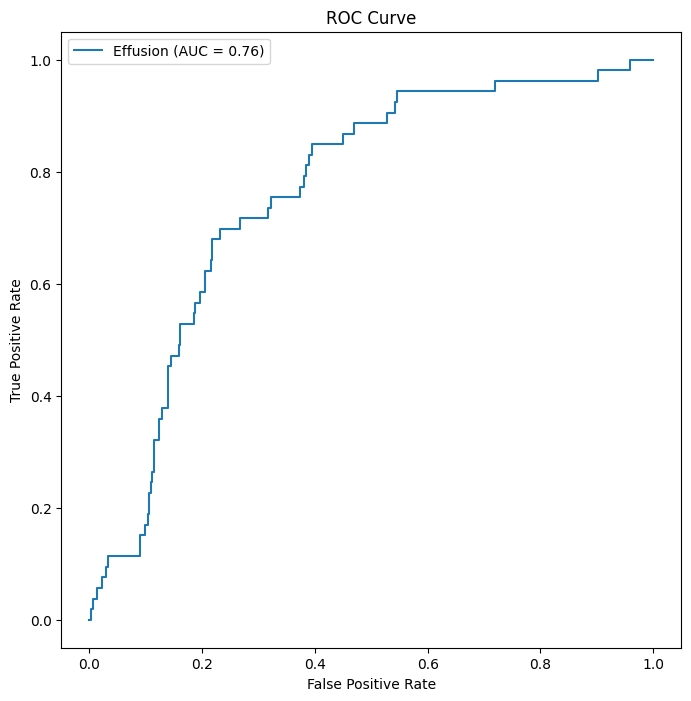

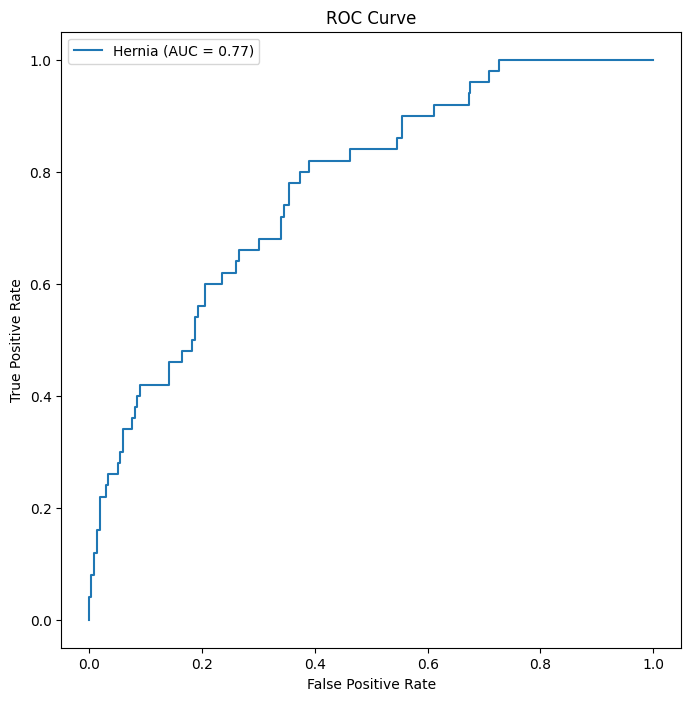

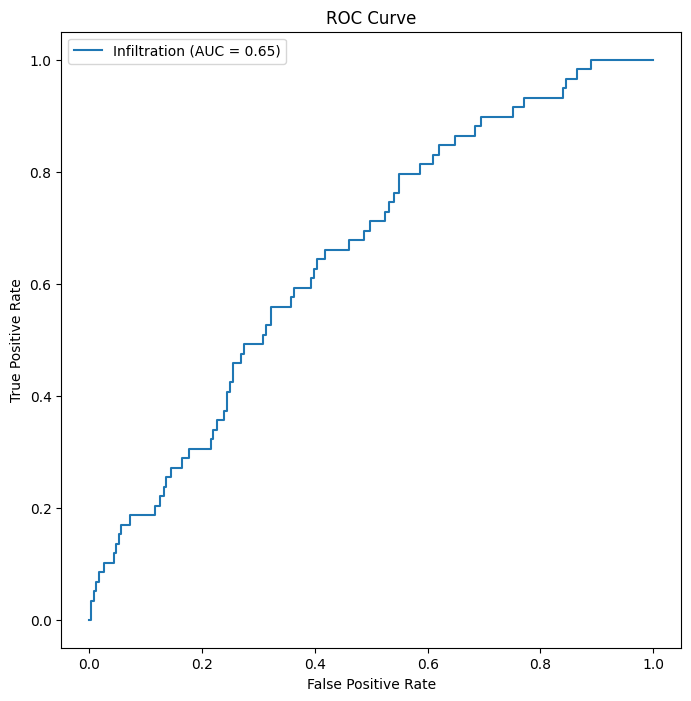

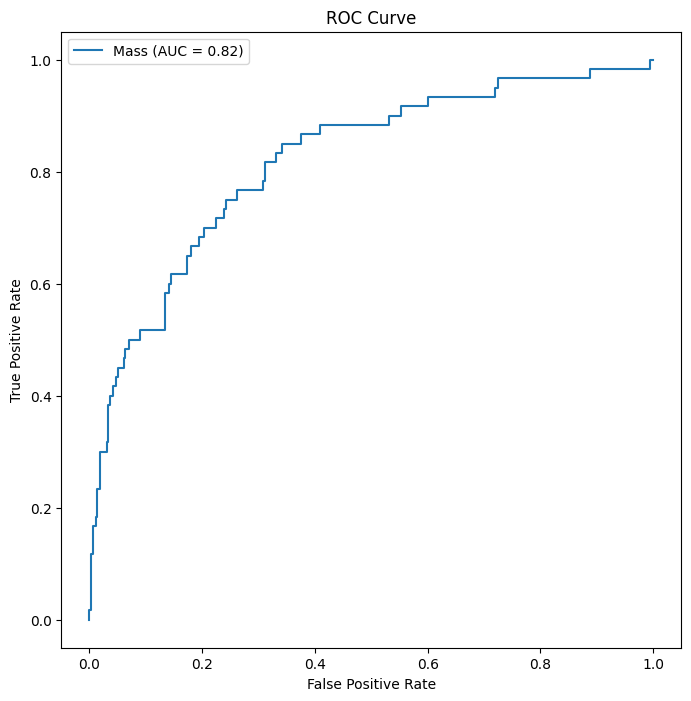

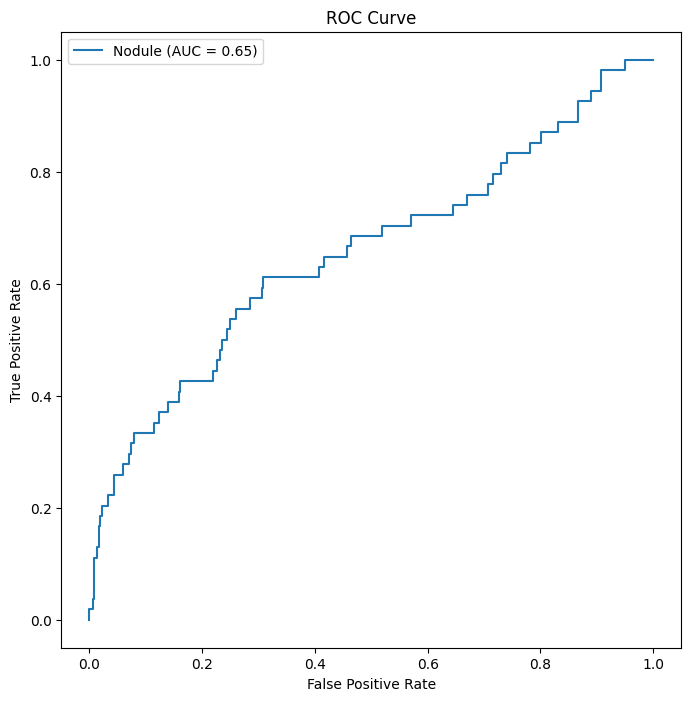

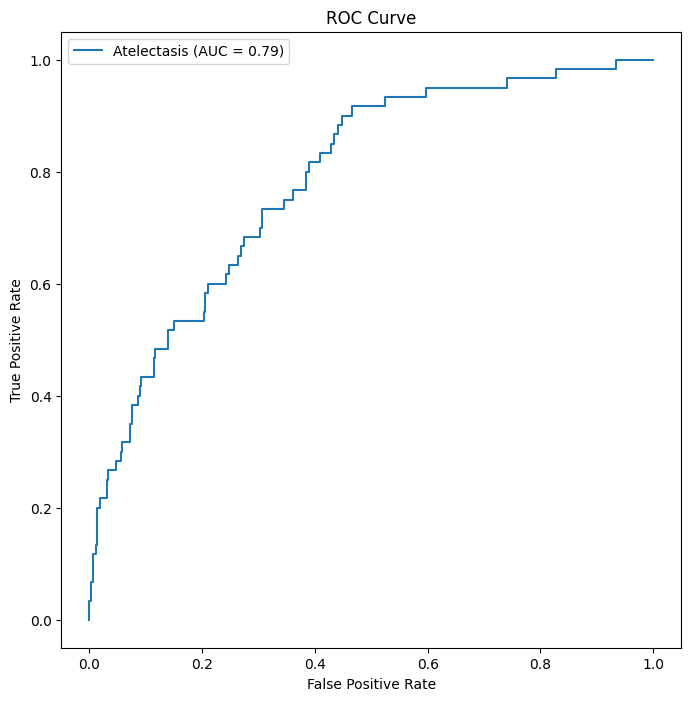

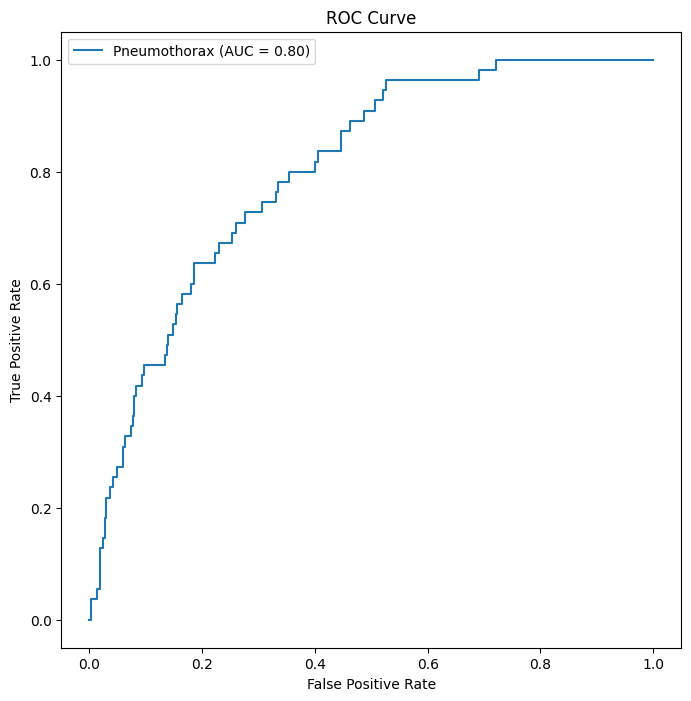

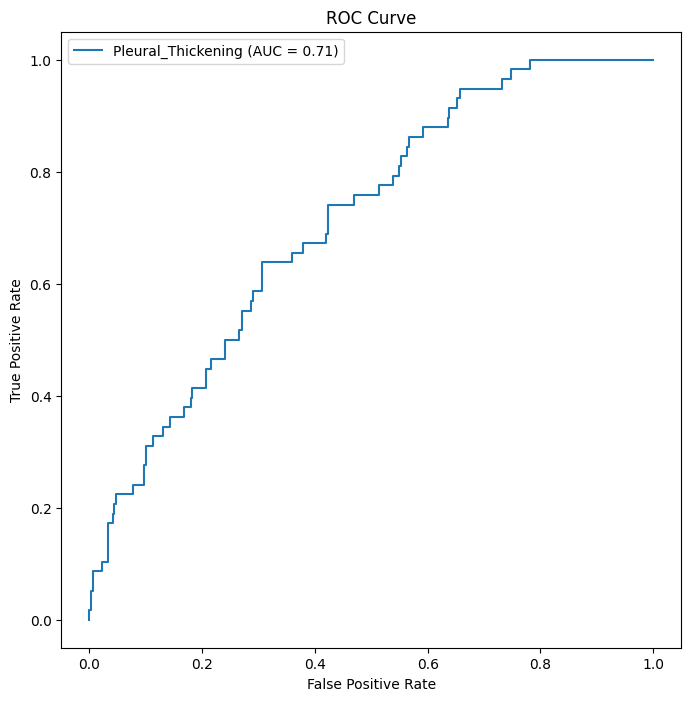

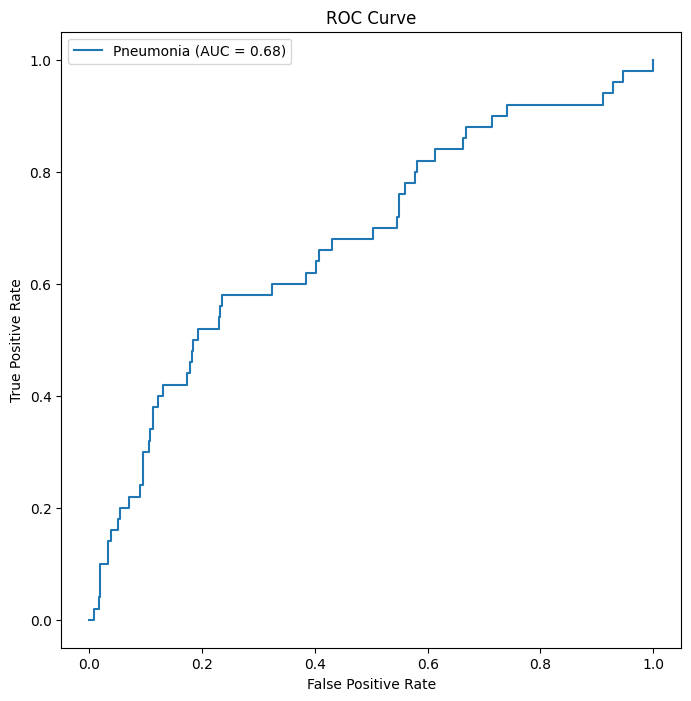

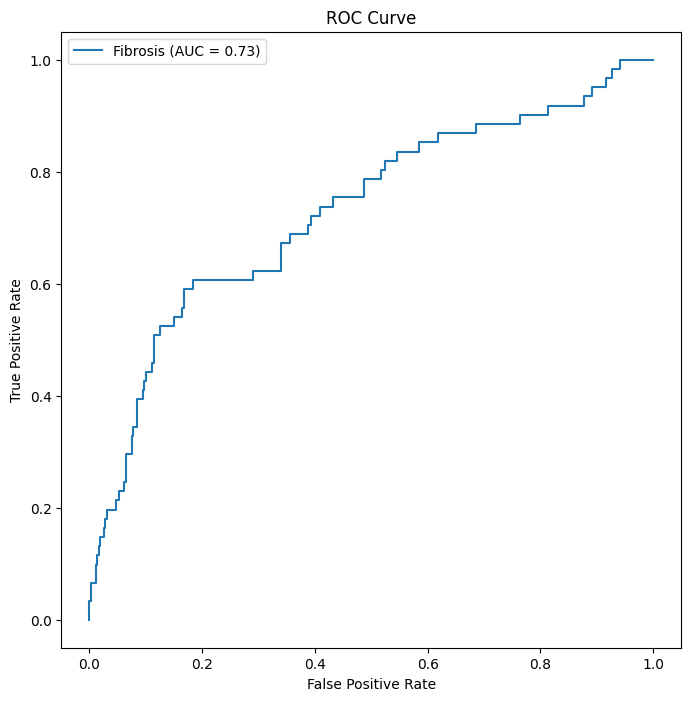

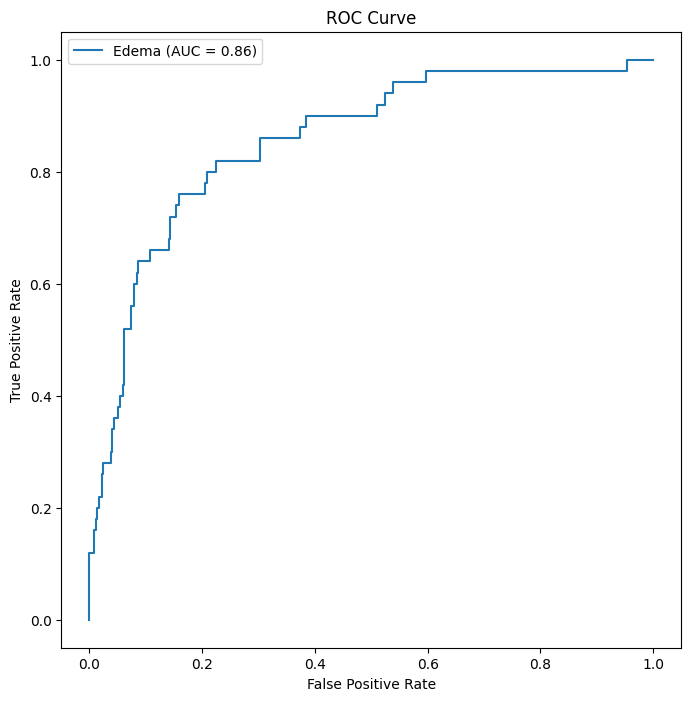

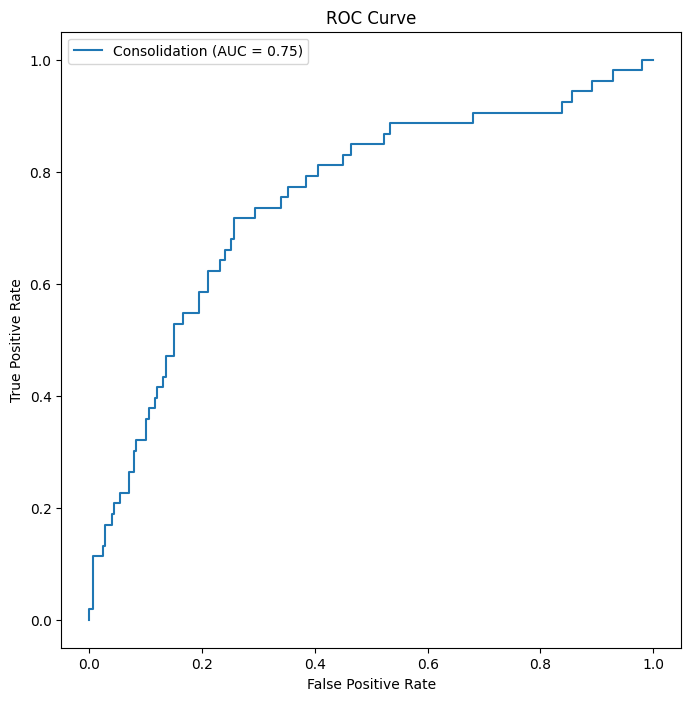

In [43]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def get_roc_curve(labels, predicted_vals, generator):
    num_classes = len(labels)
    auc_rocs = []

    # Loop through each class
    for i in range(num_classes):
        fpr, tpr, thresholds = roc_curve(generator.labels[:, i], predicted_vals[:, i])
        roc_auc = auc(fpr, tpr)
        auc_rocs.append(roc_auc)

        # Plot ROC curve
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc:.2f})')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()

        # Print numeric AUC value
        print(f'{labels[i]} AUC: {roc_auc:.4f}')

    plt.show()

    return auc_rocs

# Example usage:
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)


In [44]:
df = pd.read_csv("/content/train-small.csv")
IMAGE_DIR = "/content/datasets/images"

# show all 14 lables
df = pd.read_csv("/content/train-small.csv")
IMAGE_DIR = "/content/datasets/images"

#  14 labels based on AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:14]


Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Edema
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Emphysema
Generating gradcam for class Atelectasis
Generating gradcam for class Hernia
Generating gradcam for class Effusion
Generating gradcam for class Consolidation
Generating gradcam for class Fibrosis
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Pneumonia
Generating gradcam for class Nodule
Generating gradcam for class Infiltration


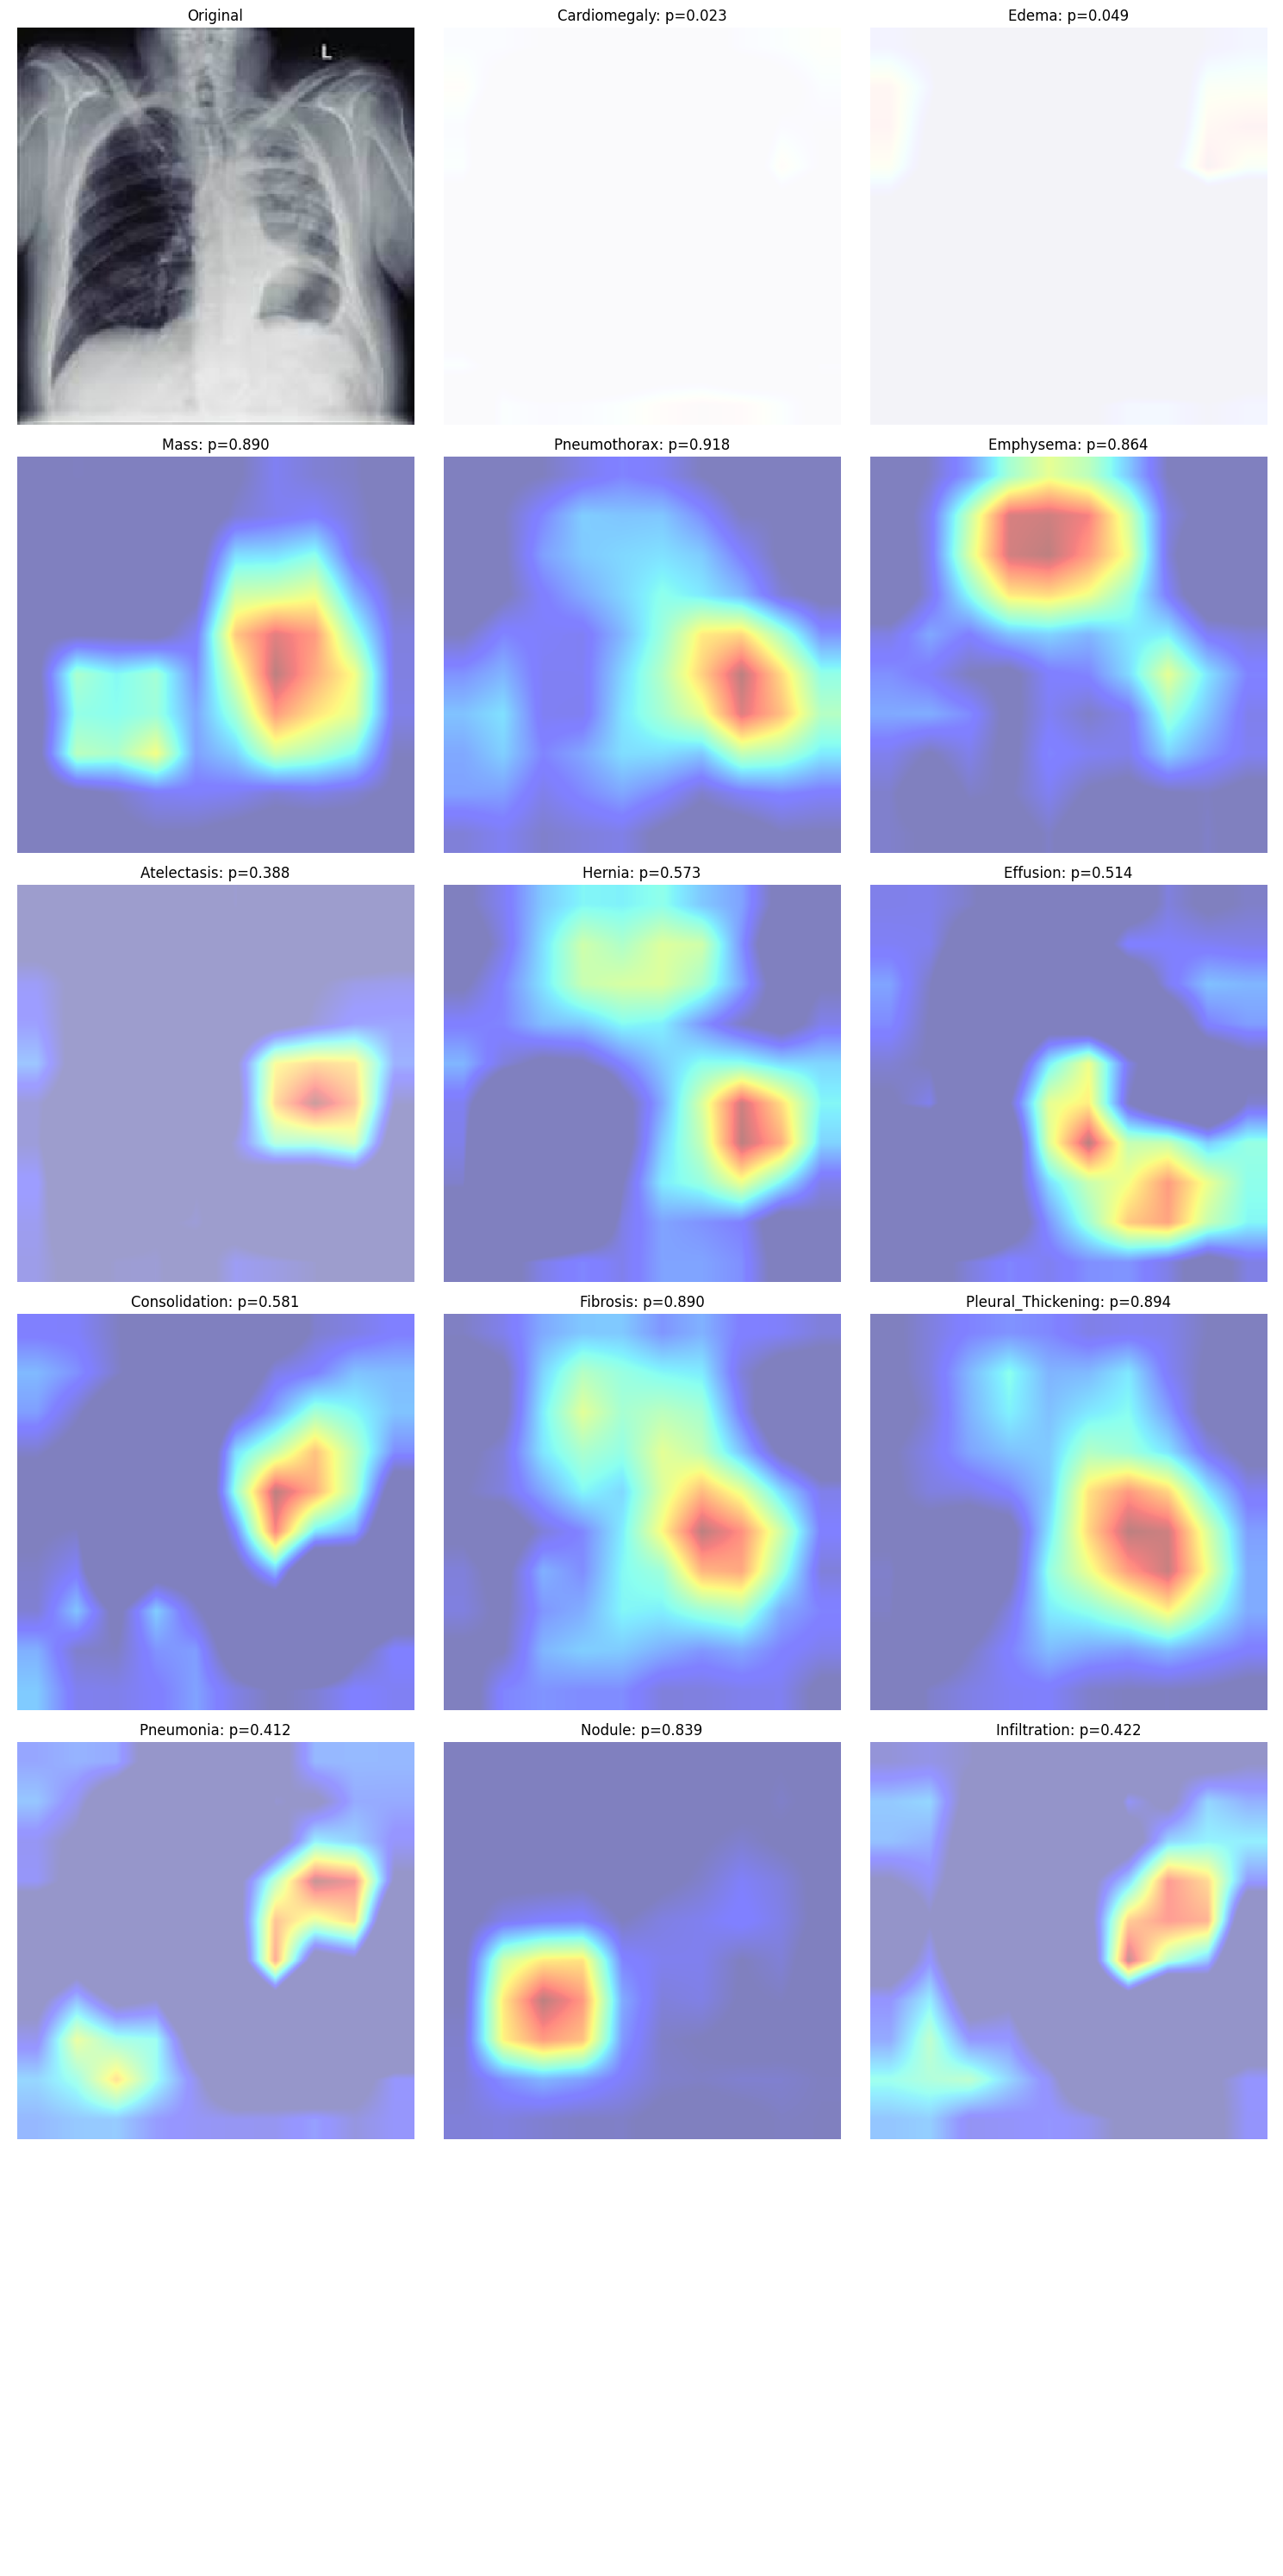

In [54]:
util2.compute_gradcam(model, r'/PLUERAL.jpeg', IMAGE_DIR, df, labels, labels_to_show)

In [55]:
df = pd.read_csv("/content/train-small.csv")
IMAGE_DIR = "/content/datasets/images"

#only show the lables with top 14 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:14]

In [56]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity

random.seed(a=None, version=2)
set_verbosity(INFO)

def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))
    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std

def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

def grad_cam(input_model, image, cls, layer_name, H=320, W=320):
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

def compute_gradcam_with_top_predictions(model, img, image_dir, df, labels, top_k=4, layer_name='bn'):
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)

    print("Loading original image")
    num_rows = (top_k + 1) // 3 + 1

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

    # Plot original image
    axes[0, 0].imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')
    axes[0, 0].set_title("Original")
    axes[0, 0].axis('off')

    # Get top k predicted classes and probabilities
    top_k_indices = np.argsort(predictions[0])[::-1][:top_k]
    top_k_labels = [labels[idx] for idx in top_k_indices]
    top_k_probs = predictions[0][top_k_indices]

    # Plot GradCAM for each top predicted label
    for j, (label, prob) in enumerate(zip(top_k_labels, top_k_probs), start=1):
        i = labels.index(label)
        print(f"Generating gradcam for class {label}")
        gradcam = grad_cam(model, preprocessed_input, i, layer_name)
        row, col = divmod(j, 3)
        axes[row, col].imshow(gradcam, cmap='jet', alpha=min(0.5, prob))
        axes[row, col].set_title(f"{label}: p={prob:.3f}")
        axes[row, col].axis('off')

    # Hide any empty subplots
    for j in range(top_k + 1, num_rows * 3):
        row, col = divmod(j, 3)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()


In [61]:
import utilfull
# # Assuming you have the model, img, image_dir, df, labels, and selected_labels defined
# compute_gradcam_with_prediction(model, '/00000246_017.png',IMAGE_DIR, df, labels, labels_to_show)

In [58]:
IMAGE_DIR="/content"

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Edema
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Emphysema
Generating gradcam for class Atelectasis
Generating gradcam for class Hernia
Generating gradcam for class Effusion
Generating gradcam for class Consolidation
Generating gradcam for class Fibrosis
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Pneumonia
Generating gradcam for class Nodule
Generating gradcam for class Infiltration
The person is likely suffering from Atelectasis with a probability of 0.839


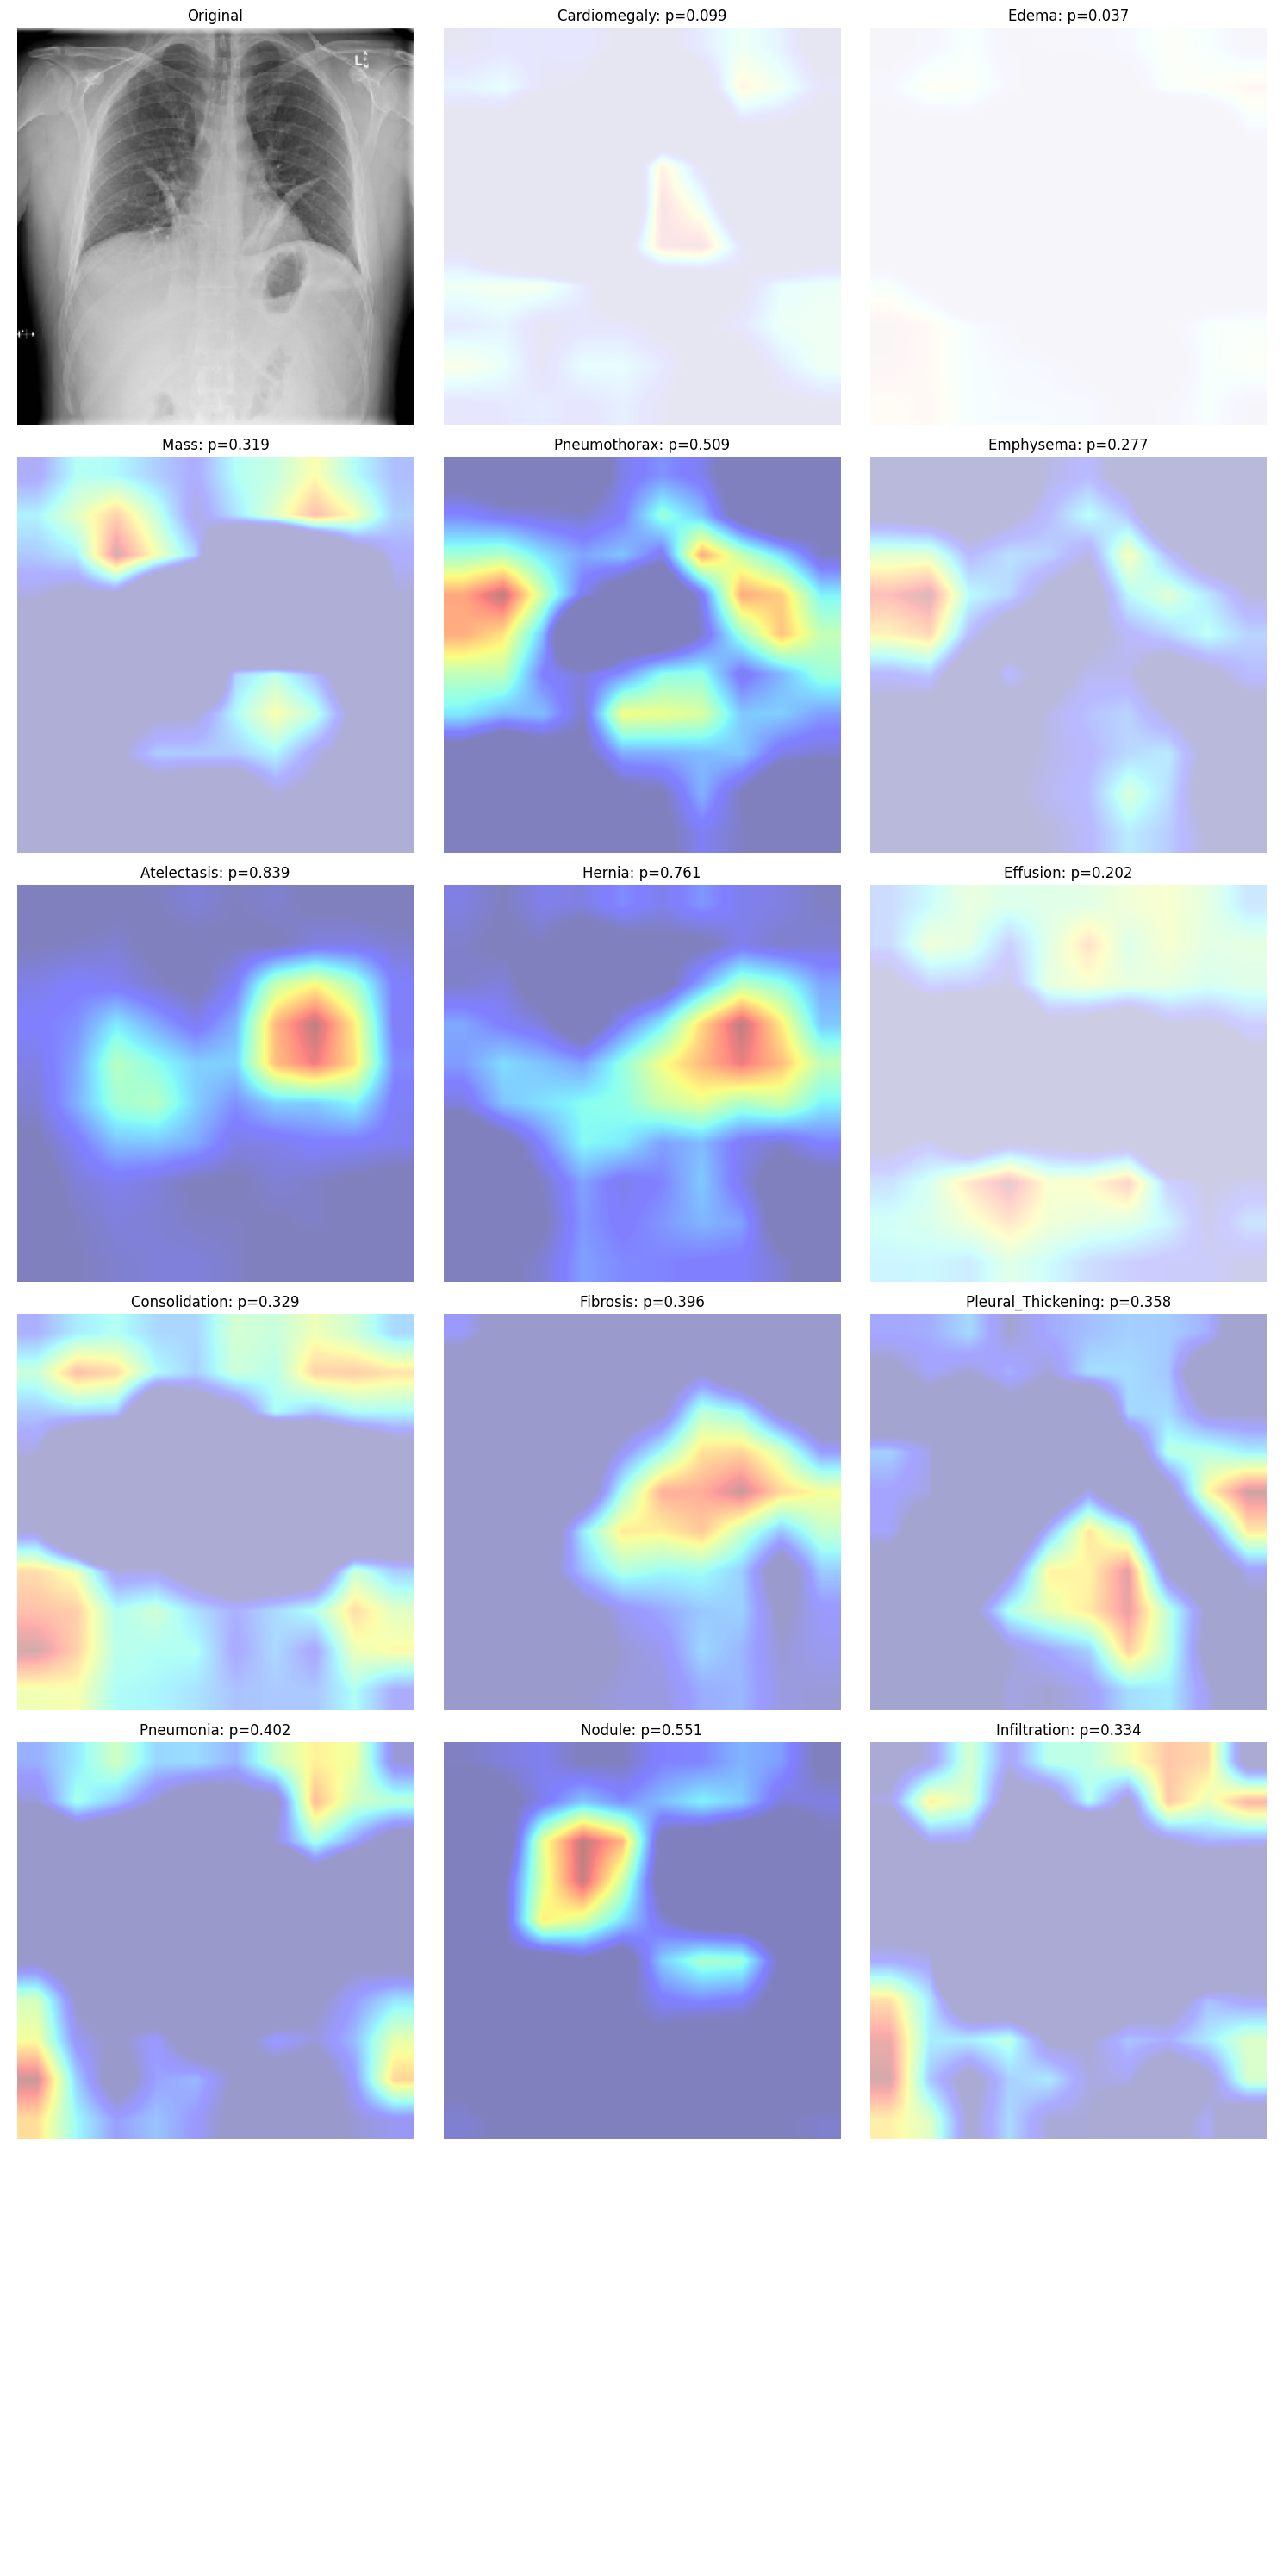

In [62]:

# Assuming you have the model, img, image_dir, df, labels, and selected_labels defined
utilfull.compute_gradcam_with_prediction(model, '/atel.jpeg',IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Edema
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Emphysema
Generating gradcam for class Atelectasis
Generating gradcam for class Hernia
Generating gradcam for class Effusion
Generating gradcam for class Consolidation
Generating gradcam for class Fibrosis
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Pneumonia
Generating gradcam for class Nodule
Generating gradcam for class Infiltration
The person is likely suffering from Fibrosis with a probability of 0.681


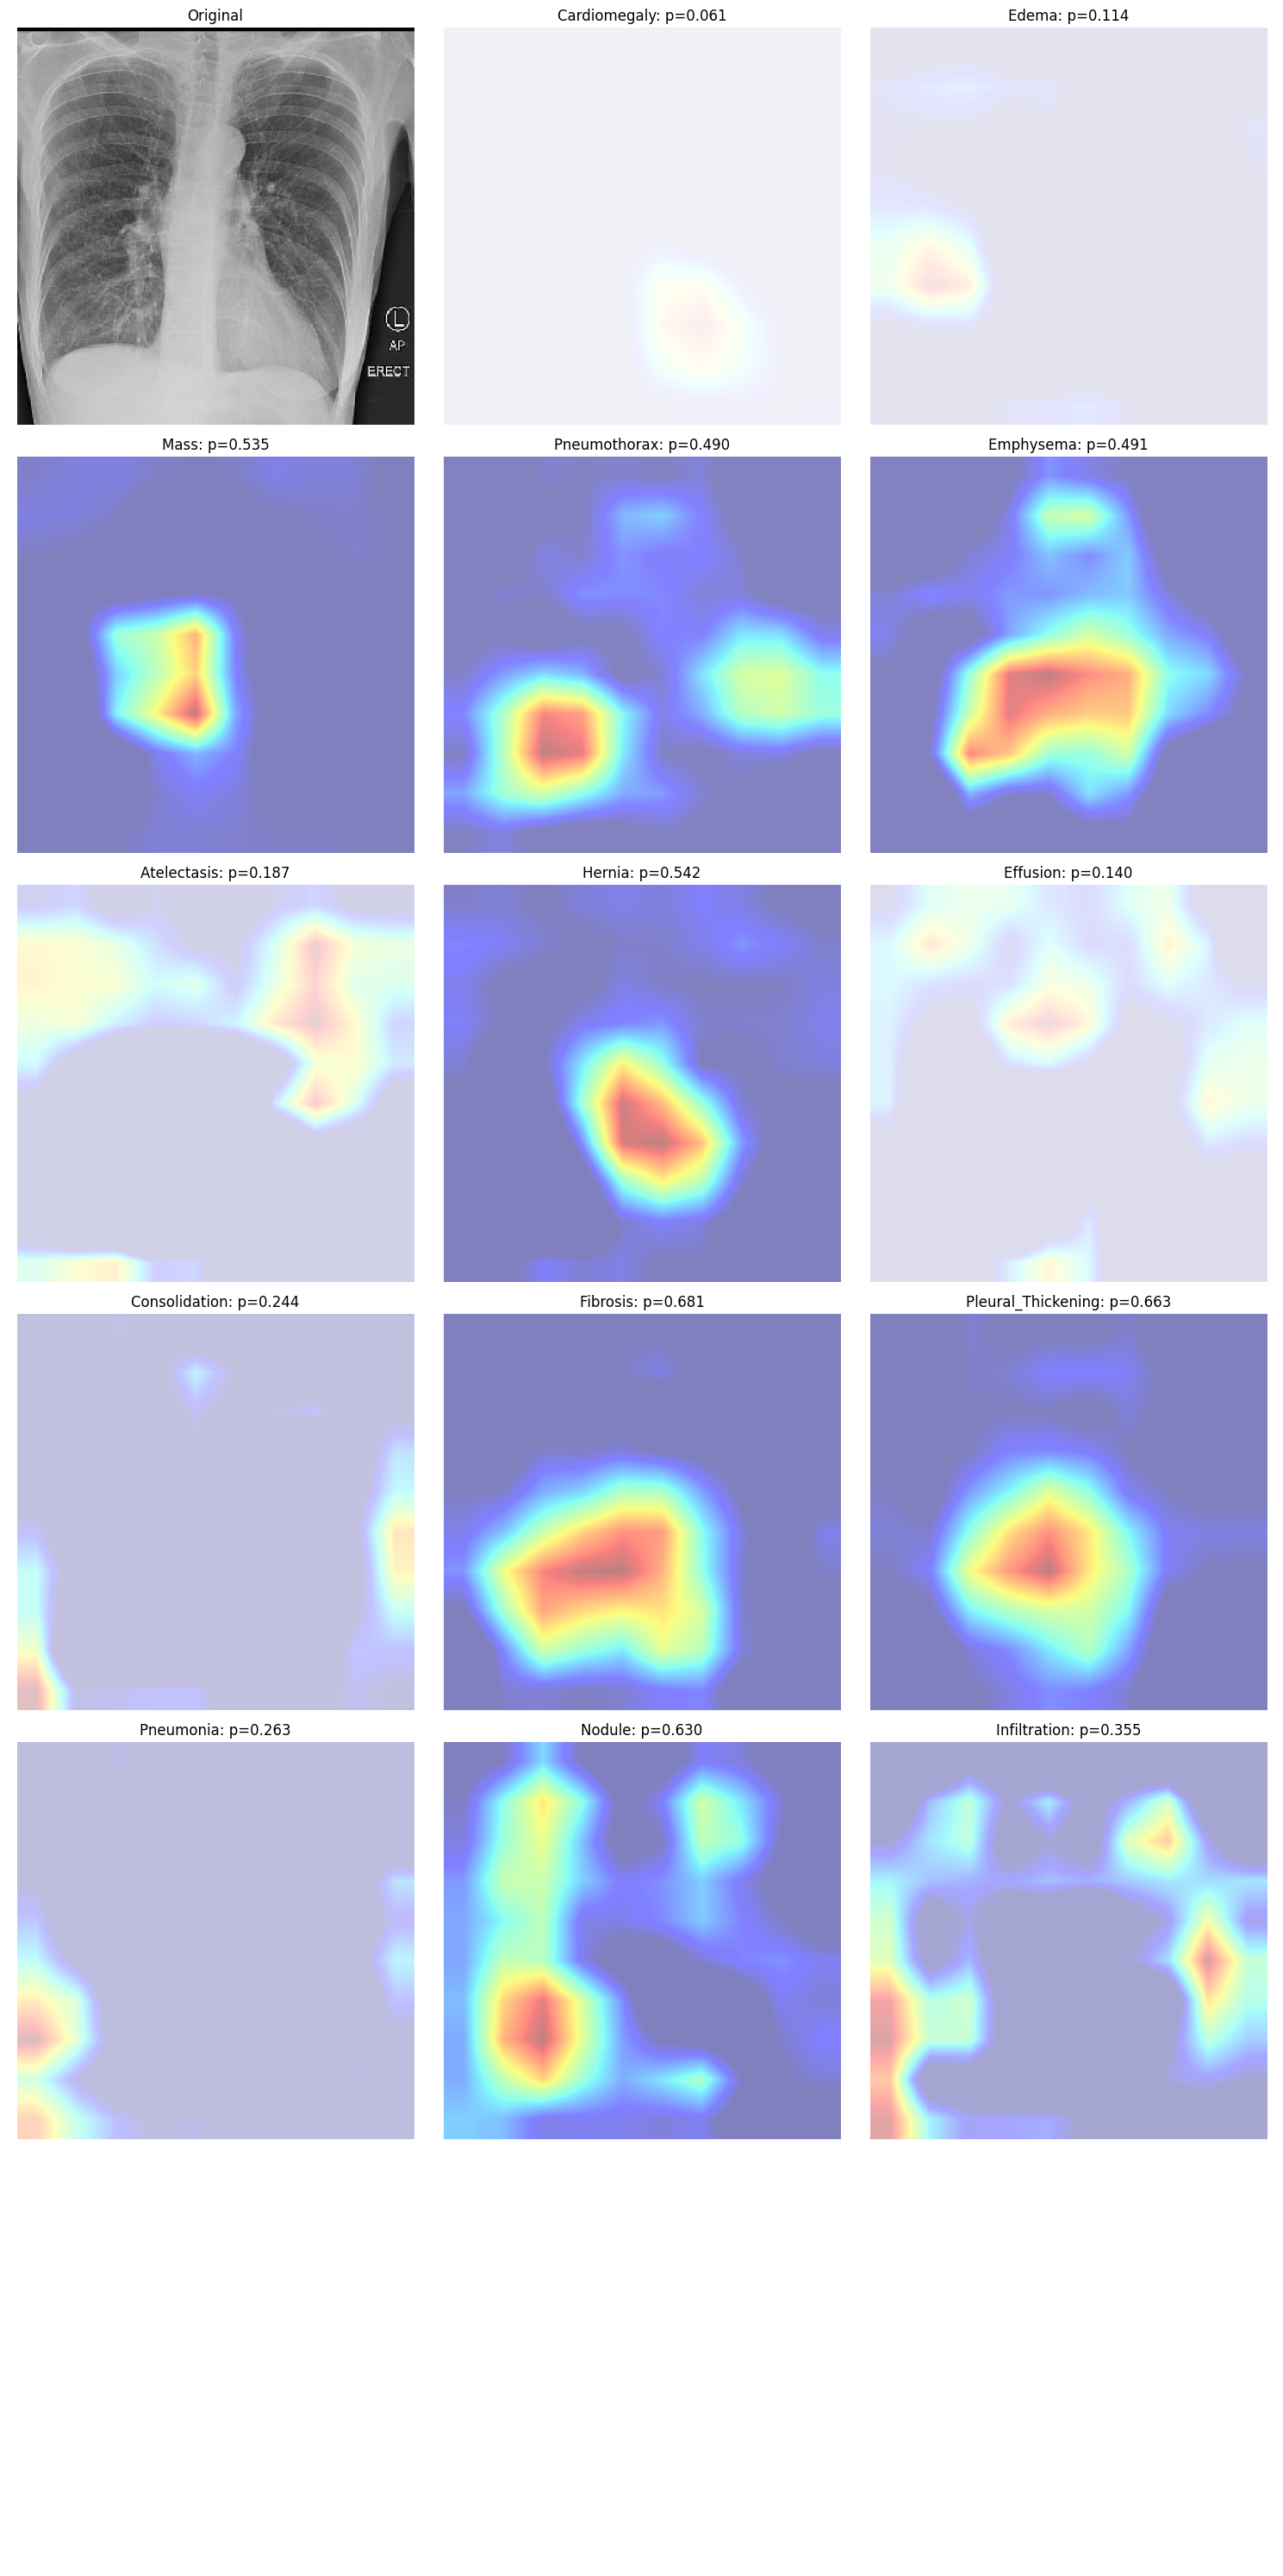

In [ ]:

# Assuming you have the model, img, image_dir, df, labels, and selected_labels defined
compute_gradcam_with_prediction(model, '/Emphy.jpg',IMAGE_DIR, df, labels, labels_to_show)